In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from adjustText import adjust_text
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CONFIGURATION & DIRECTORIES
# ==========================================
OUTPUT_DIR = Path("7_visualisations/normalized_analysis_v2") # Updated version number
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CSV1 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_23keywords_v2.csv"
CSV2 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_run1_15_keywords.csv"

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
STANCE_COLORS = {'favor': '#2ecc71', 'against': '#e74c3c', 'neutral': '#95a5a6'}
PARTY_COLORS = {'pro ruling': '#FF6B35', 'pro opposition': '#004E89'}
BUCKET_COLORS = {
    'Economic': '#1abc9c', 'Social/Religious': '#9b59b6', 
    'Political/Policy': '#3498db', 'Leadership': '#e67e22', 'Other': '#7f8c8d'
}

# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================
def load_data():
    dfs = []
    # Loads data from BOTH CSV1 and CSV2
    for p in [CSV1, CSV2]:
        if Path(p).exists():
            dfs.append(pd.read_csv(p))
    
    if not dfs:
        raise FileNotFoundError("No input CSV files found. Please check paths.")
        
    df = pd.concat(dfs, axis=0, ignore_index=True).drop_duplicates(subset=['source_row', 'keyword'])
    
    # Filter and Normalize stance labels
    df = df[df['fewshot_label'].isin(['favor', 'against', 'neutral'])].copy()
    df['stance'] = df['fewshot_label']
    df['party'] = df['_label_norm'].str.lower().str.strip()
    df['keyword'] = df['keyword'].str.lower().str.strip()
    return df[df['party'].isin(['pro ruling', 'pro opposition'])]

# Keyword Bucketing Definition
KEYWORD_BUCKETS = {
    'Economic': ['gdp', 'inflation', 'unemployment', 'msp', 'aatmanirbhar', 'economy', 'budget'],
    'Social/Religious': ['ayodhya', 'minorities', 'islamists', 'sangh', 'hathras', 'ucc', 'hindu', 'hindus', 'muslim', 'muslims', 'ram'],
    'Political/Policy': ['caa', 'farm', 'democracy', 'mahotsav', 'bjp', 'congress', 'election', 'protest', 'farmers'],
    'Leadership': ['modi', 'bhakts', 'rahul', 'gandhi', 'pm']
}

def get_bucket(kw):
    for b, kws in KEYWORD_BUCKETS.items():
        if any(x in kw.lower() for x in kws): return b
    return 'Other'

df_main = load_data()
df_main['bucket'] = df_main['keyword'].apply(get_bucket)

# ==========================================
# 3. NORMALIZED PLOTTING FUNCTIONS
# ==========================================

def plot_normalized_overall_stance(df):
    ct = pd.crosstab(df['party'], df['stance'], normalize='index') * 100
    ct = ct[['favor', 'neutral', 'against']]
    counts = df['party'].value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ct.plot(kind='bar', stacked=True, color=[STANCE_COLORS[c] for c in ct.columns], ax=ax)
    plt.title(f"Overall Stance Distribution (Normalized %)\nN: Ruling={counts['pro ruling']}, Opp={counts['pro opposition']}")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=0)
    
    for i, party in enumerate(ct.index):
        cumsum = 0
        for stance in ct.columns:
            val = ct.loc[party, stance]
            if val > 5:
                ax.text(i, cumsum + val/2, f'{val:.1f}%', ha='center', va='center', color='white', fontweight='bold')
            cumsum += val
            
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "1_overall_stance_normalized.png")
    plt.close()

def plot_butterfly_polarization(df):
    stats = df.groupby(['keyword', 'party'])['stance'].value_counts(normalize=True).unstack(fill_value=0) * 100
    counts = df.groupby(['keyword', 'party']).size().unstack(fill_value=0)
    valid_kws = counts[(counts['pro ruling'] > 15) & (counts['pro opposition'] > 15)].index
    
    if valid_kws.empty: return

    plot_df = stats.loc[valid_kws].reset_index()
    ruling = plot_df[plot_df['party'] == 'pro ruling'].set_index('keyword')
    opp = plot_df[plot_df['party'] == 'pro opposition'].set_index('keyword')
    diff = (ruling['favor'] - opp['favor']).sort_values()
    
    fig, ax = plt.subplots(figsize=(12, 12))
    y_pos = np.arange(len(diff))
    ax.barh(y_pos, -opp.loc[diff.index, 'favor'], color=PARTY_COLORS['pro opposition'], label='Opposition Favor %')
    ax.barh(y_pos, ruling.loc[diff.index, 'favor'], color=PARTY_COLORS['pro ruling'], label='Ruling Favor %')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{kw} (N={counts.loc[kw, 'pro ruling']}/{counts.loc[kw, 'pro opposition']})" for kw in diff.index])
    ax.axvline(0, color='black', lw=1)
    plt.title("Normalized Favor Comparison: Ruling vs Opposition")
    plt.xlabel("← Opposition % Favor | Ruling % Favor →")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "2_butterfly_favor_normalized.png")
    plt.close()

def plot_divergence_scatter(df):
    res = []
    for kw in df['keyword'].unique():
        for p in ['pro ruling', 'pro opposition']:
            sub = df[(df['keyword'] == kw) & (df['party'] == p)]
            if len(sub) < 10: continue
            pcts = sub['stance'].value_counts(normalize=True) * 100
            res.append({'keyword': kw, 'party': p, 'favor': pcts.get('favor', 0), 'against': pcts.get('against', 0), 'n': len(sub)})
    
    pdf = pd.DataFrame(res)
    if pdf.empty: return
    pivot = pdf.pivot(index='keyword', columns='party', values=['favor', 'against', 'n']).dropna()
    
    fav_diff = (pivot['favor']['pro ruling'] - pivot['favor']['pro opposition']).values
    agn_diff = (pivot['against']['pro ruling'] - pivot['against']['pro opposition']).values
    total_n = (pivot['n']['pro ruling'] + pivot['n']['pro opposition']).values
    keywords = pivot.index.tolist()
    
    fig, ax = plt.subplots(figsize=(16, 12))
    # Increased multiplier for better bubble visibility
    scatter = ax.scatter(fav_diff, agn_diff, s=total_n * 4, alpha=0.6, c=fav_diff, cmap='RdYlGn', edgecolors='k')
    
    texts = [ax.text(fav_diff[i], agn_diff[i], keywords[i], fontsize=10, fontweight='bold') for i in range(len(keywords))]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.4)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.4)
    
    # =========================================
    # QUADRANT LABELS
    # =========================================
    # Using axes coordinates (0 to 1) for corner placement
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    
    # Top Right (+Favor Diff, +Against Diff)
    ax.text(0.98, 0.98, 'Ruling more Polarized/Vocal\n(Higher % in both Favor & Against)', 
            transform=ax.transAxes, ha='right', va='top', fontweight='bold', color=PARTY_COLORS['pro ruling'], bbox=bbox_props)

    # Bottom Right (+Favor Diff, -Against Diff)
    ax.text(0.98, 0.02, 'Ruling Favors,\nOpp Against', 
            transform=ax.transAxes, ha='right', va='bottom', fontweight='bold', color='green', bbox=bbox_props)
            
    # Top Left (-Favor Diff, +Against Diff)
    ax.text(0.02, 0.98, 'Opp Favors,\nRuling Against', 
            transform=ax.transAxes, ha='left', va='top', fontweight='bold', color='red', bbox=bbox_props)
            
    # Bottom Left (-Favor Diff, -Against Diff)
    ax.text(0.02, 0.02, 'Opp more Polarized/Vocal\n(Higher % in both Favor & Against)', 
            transform=ax.transAxes, ha='left', va='bottom', fontweight='bold', color=PARTY_COLORS['pro opposition'], bbox=bbox_props)


    plt.xlabel("Favor Difference (Ruling % - Opp %)", fontweight='bold', fontsize=12)
    plt.ylabel("Against Difference (Ruling % - Opp %)", fontweight='bold', fontsize=12)
    plt.title("Normalized Stance Divergence Scatter with Quadrant Analysis", fontweight='bold', fontsize=14)
    plt.colorbar(scatter, label='Favor Divergence Score')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "3_normalized_divergence_scatter_labeled.png")
    plt.close()

def plot_radar_focus(df):
    bucket_counts = df.groupby(['party', 'bucket']).size().unstack(fill_value=0)
    bucket_pct = bucket_counts.div(bucket_counts.sum(axis=1), axis=0) * 100

    categories = bucket_pct.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for party, color in PARTY_COLORS.items():
        if party in bucket_pct.index:
            values = bucket_pct.loc[party].values.tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=party.title(), color=color)
            ax.fill(angles, values, color=color, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=12, fontweight='bold')
    plt.title("Normalized Party Focus Across Topic Buckets", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.savefig(OUTPUT_DIR / "4_normalized_radar_focus.png")
    plt.close()

# ==========================================
# 4. EXECUTION
# ==========================================
print(f"Generating labeled visualizations in: {OUTPUT_DIR}")
plot_normalized_overall_stance(df_main)
plot_butterfly_polarization(df_main)
plot_divergence_scatter(df_main)
plot_radar_focus(df_main)
print("Processing Complete.")

Generating labeled visualizations in: 7_visualisations/normalized_analysis_v2
Processing Complete.


In [2]:
!pip install adjustText

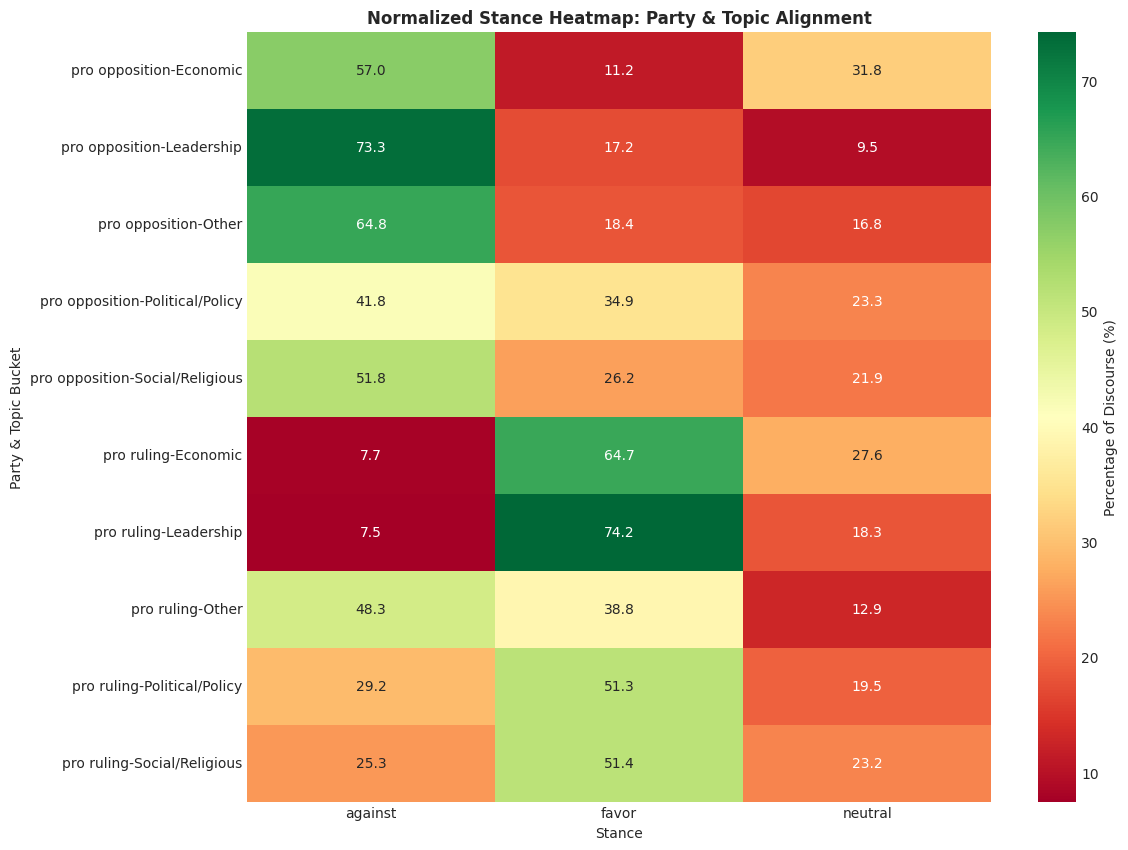

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Data (Assumes your df has 'party', 'bucket', and 'stance' columns)
# Creating a cross-tabulation of Party/Bucket vs Stance
heatmap_data = pd.crosstab([df['party'], df['bucket']], df['stance'])

# 2. Normalize by row (Total within each Party-Bucket combination)
# Formula: P(stance | party, bucket) = count / sum(counts)
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# 3. Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_norm, 
            annot=True, 
            fmt=".1f", 
            cmap="RdYlGn", # Red for Against, Green for Favor
            cbar_kws={'label': 'Percentage of Discourse (%)'})

plt.title("Normalized Stance Heatmap: Party & Topic Alignment", fontweight='bold')
plt.ylabel("Party & Topic Bucket")
plt.xlabel("Stance")
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from adjustText import adjust_text
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CONFIGURATION & DIRECTORIES
# ==========================================
OUTPUT_DIR = Path("7_visualisations/normalized_analysis_v3_compact")  # Version incremented
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CSV1 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_23keywords_v2.csv"
CSV2 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_run1_15_keywords.csv"

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
STANCE_COLORS = {'favor': '#2ecc71', 'against': '#e74c3c', 'neutral': '#95a5a6'}
PARTY_COLORS = {'pro ruling': '#FF6B35', 'pro opposition': '#004E89'}
BUCKET_COLORS = {
    'Economic': '#1abc9c', 'Social/Religious': '#9b59b6',
    'Political/Policy': '#3498db', 'Leadership': '#e67e22', 'Other': '#7f8c8d'
}

# Font sizes
FS_TITLE = 16
FS_LABEL = 12
FS_TICK = 10
FS_ANNOT = 9
FS_QUAD = 10


# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================
def load_data():
    dfs = []
    # Loads data from BOTH CSV1 and CSV2
    for p in [CSV1, CSV2]:
        if Path(p).exists():
            dfs.append(pd.read_csv(p))

    if not dfs:
        raise FileNotFoundError("No input CSV files found. Please check paths.")

    df = pd.concat(dfs, axis=0, ignore_index=True).drop_duplicates(subset=['source_row', 'keyword'])

    # Filter and Normalize stance labels
    df = df[df['fewshot_label'].isin(['favor', 'against', 'neutral'])].copy()
    df['stance'] = df['fewshot_label']
    df['party'] = df['_label_norm'].str.lower().str.strip()
    df['keyword'] = df['keyword'].str.lower().str.strip()
    return df[df['party'].isin(['pro ruling', 'pro opposition'])]


# Keyword Bucketing Definition
KEYWORD_BUCKETS = {
    'Economic': ['gdp', 'inflation', 'unemployment', 'msp', 'aatmanirbhar', 'economy', 'budget'],
    'Social/Religious': ['ayodhya', 'minorities', 'islamists', 'sangh', 'hathras', 'ucc', 'hindu', 'hindus', 'muslim',
                         'muslims', 'ram'],
    'Political/Policy': ['caa', 'farm', 'democracy', 'mahotsav', 'bjp', 'congress', 'election', 'protest', 'farmers'],
    'Leadership': ['modi', 'bhakts', 'rahul', 'gandhi', 'pm']
}


def get_bucket(kw):
    for b, kws in KEYWORD_BUCKETS.items():
        if any(x in kw.lower() for x in kws): return b
    return 'Other'


df_main = load_data()
df_main['bucket'] = df_main['keyword'].apply(get_bucket)


# ==========================================
# 3. NORMALIZED PLOTTING FUNCTIONS
# ==========================================

def plot_normalized_overall_stance(df):
    ct = pd.crosstab(df['party'], df['stance'], normalize='index') * 100
    ct = ct[['favor', 'neutral', 'against']]
    counts = df['party'].value_counts()

    fig, ax = plt.subplots(figsize=(10, 6))  # Slightly reduced height
    ct.plot(kind='bar', stacked=True, color=[STANCE_COLORS[c] for c in ct.columns], ax=ax, width=0.7)
    plt.title(f"Overall Stance Distribution (Normalized %)\nN: Ruling={counts['pro ruling']}, Opp={counts['pro opposition']}", fontsize=FS_TITLE)
    plt.ylabel("Percentage (%)", fontsize=FS_LABEL)
    plt.xticks(rotation=0, fontsize=FS_TICK)
    plt.yticks(fontsize=FS_TICK)

    for i, party in enumerate(ct.index):
        cumsum = 0
        for stance in ct.columns:
            val = ct.loc[party, stance]
            if val > 4: # Lowered threshold for annotation
                ax.text(i, cumsum + val / 2, f'{val:.0f}%', ha='center', va='center', color='white', fontweight='bold', fontsize=FS_ANNOT)
            cumsum += val

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "1_overall_stance_normalized.png")
    plt.close()


def plot_butterfly_polarization(df):
    stats = df.groupby(['keyword', 'party'])['stance'].value_counts(normalize=True).unstack(fill_value=0) * 100
    counts = df.groupby(['keyword', 'party']).size().unstack(fill_value=0)
    valid_kws = counts[(counts['pro ruling'] > 15) & (counts['pro opposition'] > 15)].index

    if valid_kws.empty: return

    plot_df = stats.loc[valid_kws].reset_index()
    ruling = plot_df[plot_df['party'] == 'pro ruling'].set_index('keyword')
    opp = plot_df[plot_df['party'] == 'pro opposition'].set_index('keyword')
    diff = (ruling['favor'] - opp['favor']).sort_values()

    # Increased figure height for better spacing between bars
    fig, ax = plt.subplots(figsize=(12, len(diff) * 0.4 + 2))
    y_pos = np.arange(len(diff))
    
    # Reduced bar height
    bar_height = 0.7
    ax.barh(y_pos, -opp.loc[diff.index, 'favor'], color=PARTY_COLORS['pro opposition'], label='Opposition Favor %', height=bar_height)
    ax.barh(y_pos, ruling.loc[diff.index, 'favor'], color=PARTY_COLORS['pro ruling'], label='Ruling Favor %', height=bar_height)
    
    ax.set_yticks(y_pos)
    # Simplified Y-axis labels (removed N counts for compactness, can add back if needed)
    ax.set_yticklabels(diff.index, fontsize=FS_TICK)
    ax.axvline(0, color='black', lw=1)
    plt.title("Normalized Favor Comparison: Ruling vs Opposition", fontsize=FS_TITLE)
    plt.xlabel("← Opposition % Favor | Ruling % Favor →", fontsize=FS_LABEL)
    plt.xticks(fontsize=FS_TICK)
    plt.legend(fontsize=FS_TICK)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "2_butterfly_favor_normalized.png")
    plt.close()


def plot_divergence_scatter(df):
    res = []
    for kw in df['keyword'].unique():
        for p in ['pro ruling', 'pro opposition']:
            sub = df[(df['keyword'] == kw) & (df['party'] == p)]
            if len(sub) < 10: continue
            pcts = sub['stance'].value_counts(normalize=True) * 100
            res.append({'keyword': kw, 'party': p, 'favor': pcts.get('favor', 0), 'against': pcts.get('against', 0),
                        'n': len(sub)})

    pdf = pd.DataFrame(res)
    if pdf.empty: return
    pivot = pdf.pivot(index='keyword', columns='party', values=['favor', 'against', 'n']).dropna()

    fav_diff = (pivot['favor']['pro ruling'] - pivot['favor']['pro opposition']).values
    agn_diff = (pivot['against']['pro ruling'] - pivot['against']['pro opposition']).values
    total_n = (pivot['n']['pro ruling'] + pivot['n']['pro opposition']).values
    keywords = pivot.index.tolist()

    fig, ax = plt.subplots(figsize=(14, 10)) # Adjusted figure size
    # Reduced bubble size slightly but kept them visible
    scatter = ax.scatter(fav_diff, agn_diff, s=total_n * 3, alpha=0.6, c=fav_diff, cmap='RdYlGn', edgecolors='k')

    # Used a slightly smaller font and different repulsion parameters for adjust_text
    texts = [ax.text(fav_diff[i], agn_diff[i], keywords[i], fontsize=FS_ANNOT, fontweight='bold') for i in
             range(len(keywords))]
    
    # More aggressive text adjustment for compactness
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                force_text=(0.2, 0.5),
                force_points=(0.2, 0.5),
                expand_points=(1.2, 1.2)
               )

    ax.axhline(0, color='gray', linestyle='--', alpha=0.4)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.4)

    # =========================================
    # COMPACT QUADRANT LABELS
    # =========================================
    # Using a tighter bounding box and smaller font
    bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.9)

    # Top Right (+Favor Diff, +Against Diff)
    ax.text(0.99, 0.99, 'Ruling more Polarized\n(High Favor & Against)',
            transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=FS_QUAD, color=PARTY_COLORS['pro ruling'],
            bbox=bbox_props)

    # Bottom Right (+Favor Diff, -Against Diff)
    ax.text(0.99, 0.01, 'Ruling Favors,\nOpp Against',
            transform=ax.transAxes, ha='right', va='bottom', fontweight='bold', fontsize=FS_QUAD, color='green',
            bbox=bbox_props)

    # Top Left (-Favor Diff, +Against Diff)
    ax.text(0.01, 0.99, 'Opp Favors,\nRuling Against',
            transform=ax.transAxes, ha='left', va='top', fontweight='bold', fontsize=FS_QUAD, color='red',
            bbox=bbox_props)

    # Bottom Left (-Favor Diff, -Against Diff)
    ax.text(0.01, 0.01, 'Opp more Polarized\n(High Favor & Against)',
            transform=ax.transAxes, ha='left', va='bottom', fontweight='bold', fontsize=FS_QUAD,
            color=PARTY_COLORS['pro opposition'], bbox=bbox_props)

    plt.xlabel("Favor Difference (Ruling % - Opp %)", fontweight='bold', fontsize=FS_LABEL)
    plt.ylabel("Against Difference (Ruling % - Opp %)", fontweight='bold', fontsize=FS_LABEL)
    plt.title("Normalized Stance Divergence Scatter with Quadrant Analysis", fontweight='bold', fontsize=FS_TITLE)
    plt.xticks(fontsize=FS_TICK)
    plt.yticks(fontsize=FS_TICK)
    
    # Compact colorbar
    cbar = plt.colorbar(scatter, label='Favor Divergence Score', pad=0.02)
    cbar.ax.tick_params(labelsize=FS_TICK)
    cbar.set_label('Favor Divergence Score', fontsize=FS_LABEL)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "3_normalized_divergence_scatter_labeled_compact.png")
    plt.close()


def plot_radar_focus(df):
    bucket_counts = df.groupby(['party', 'bucket']).size().unstack(fill_value=0)
    bucket_pct = bucket_counts.div(bucket_counts.sum(axis=1), axis=0) * 100

    categories = bucket_pct.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

    for party, color in PARTY_COLORS.items():
        if party in bucket_pct.index:
            values = bucket_pct.loc[party].values.tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=party.title(), color=color)
            ax.fill(angles, values, color=color, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=FS_LABEL, fontweight='bold')
    ax.tick_params(axis='y', labelsize=FS_TICK)
    
    plt.title("Normalized Party Focus Across Topic Buckets", size=FS_TITLE, fontweight='bold', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1), fontsize=FS_TICK)
    plt.savefig(OUTPUT_DIR / "4_normalized_radar_focus.png")
    plt.close()


# ==========================================
# 4. EXECUTION
# ==========================================
print(f"Generating compact labeled visualizations in: {OUTPUT_DIR}")
plot_normalized_overall_stance(df_main)
plot_butterfly_polarization(df_main)
plot_divergence_scatter(df_main)
plot_radar_focus(df_main)
print("Processing Complete.")

Generating compact labeled visualizations in: 7_visualisations/normalized_analysis_v3_compact


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Processing Complete.
